In [1]:
pip install segyio

Defaulting to user installation because normal site-packages is not writeable
     |████████████████████████████████| 82 kB 904 kB/s  eta 0:00:01
You should consider upgrading via the '/Library/Developer/CommandLineTools/usr/bin/python3 -m pip install --upgrade pip' command.
Note: you may need to restart the kernel to use updated packages.


In [10]:
pip install obspy numpy matplotlib

Defaulting to user installation because normal site-packages is not writeable
     |████████████████████████████████| 14.1 MB 686 kB/s eta 0:00:01
     |████████████████████████████████| 8.5 MB 15.9 MB/s eta 0:00:01
     |████████████████████████████████| 64 kB 23.5 MB/s eta 0:00:01
     |████████████████████████████████| 8.4 MB 92.5 MB/s eta 0:00:01
     |████████████████████████████████| 129 kB 23.5 MB/s eta 0:00:01
     |████████████████████████████████| 207 kB 79.2 MB/s eta 0:00:01
     |████████████████████████████████| 70 kB 30.8 MB/s eta 0:00:01
  Created wheel for sqlalchemy: filename=SQLAlchemy-1.4.54-cp39-cp39-macosx_10_9_universal2.whl size=1588220 sha256=3f1e1636c579672689f12833791f00ec4849dd6443577c37e6c627702957feed
  Stored in directory: /Users/haonanzhang/Library/Caches/pip/wheels/76/d6/51/e82ea8caaec4f0dd1756493d8ecec6a75f49d152f7d2ede4e1
Successfully built sqlalchemy
You should consider upgrading via the '/Library/Developer/CommandLineTools/usr/bin/python3 -m pip inst

Trace count: 2481


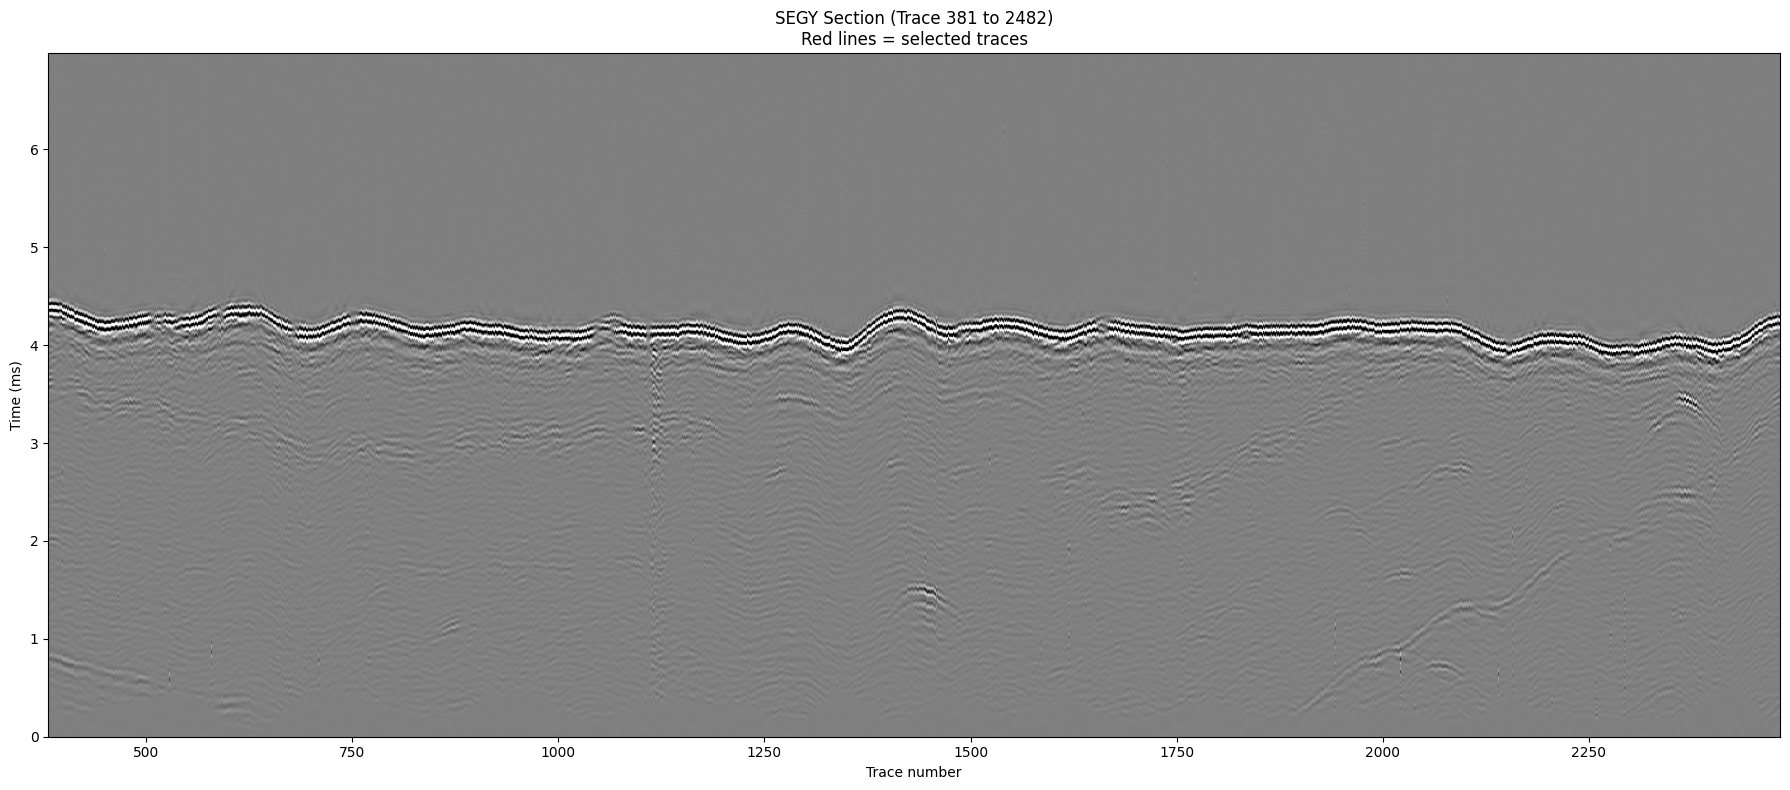

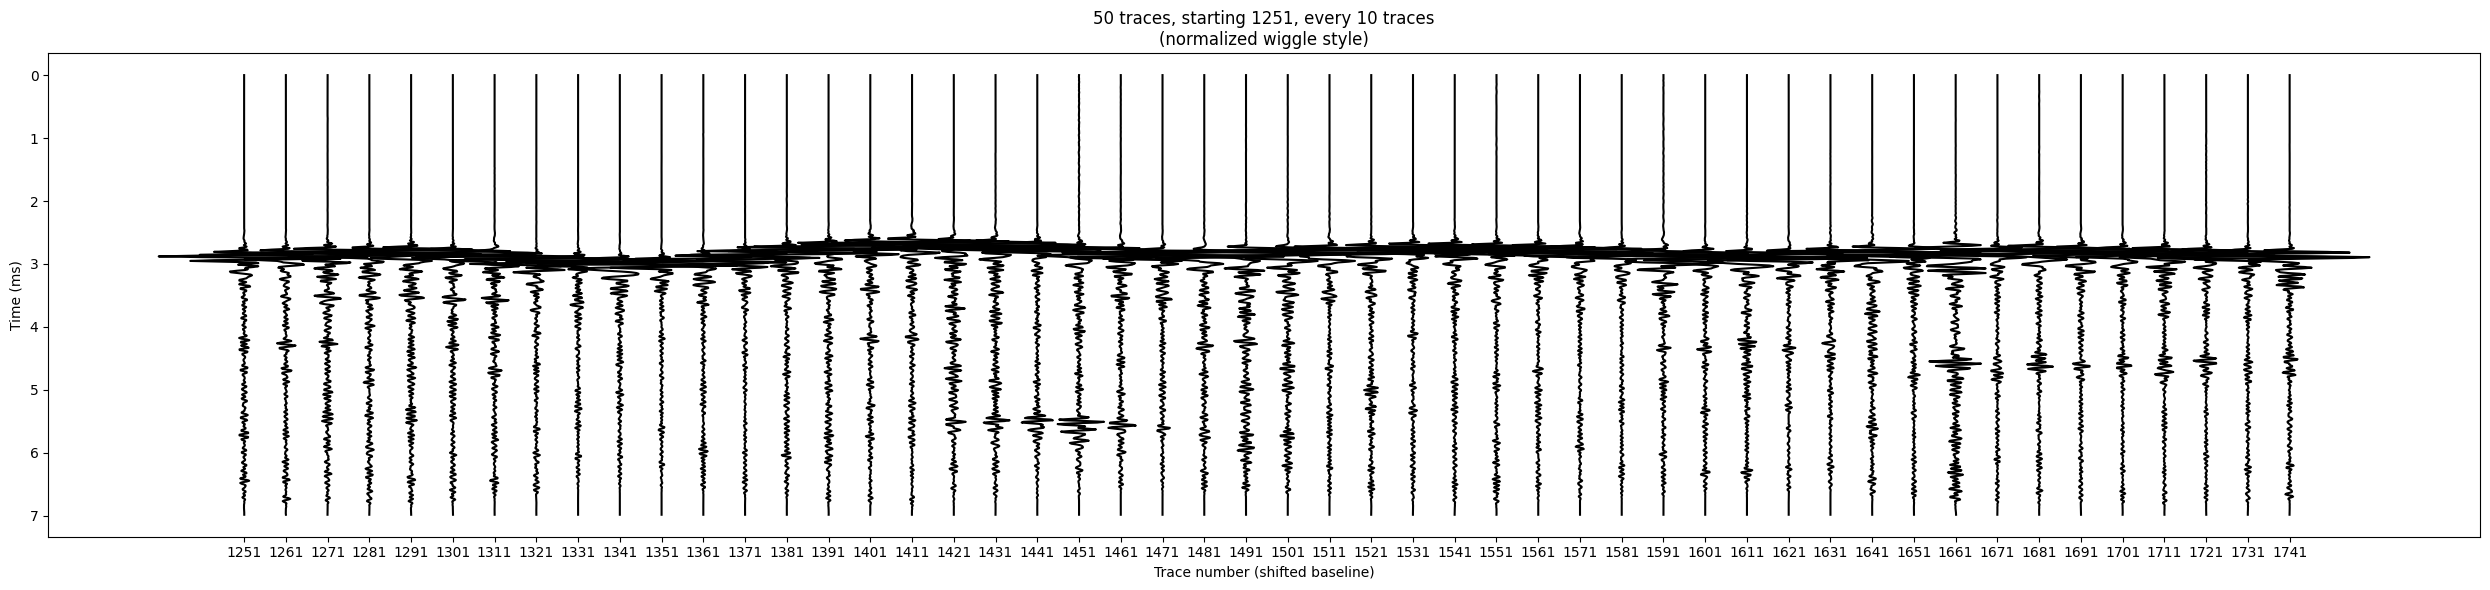

In [148]:
# pip install obspy numpy matplotlib
import numpy as np
import matplotlib.pyplot as plt
from obspy.io.segy.segy import _read_segy

SEGY_PATH = "processed/output_bp_5k_20k_TGC_power_n1p5.sgy"
sf = _read_segy(SEGY_PATH, headonly=False)
n_traces = len(sf.traces)
print("Trace count:", n_traces)

# ---- Get sampling interval dt (milliseconds) ----
def get_dt_ms(segfile, fallback_ms=1.0):
    try:
        dt = segfile.binary_file_header.sample_interval_in_microseconds
        if dt and dt > 0:
            return dt / 1000.0
    except: pass
    try:
        dt = segfile.traces[0].stats.delta  # s
        if dt and dt > 0:
            return dt * 1000.0
    except: pass
    print(f"[WARN] No dt in headers; using fallback {fallback_ms} ms.")
    return fallback_ms

dt_ms = get_dt_ms(sf)

# ---- 2d trace range ----
start_trace = 380
end_trace   = 2481
trace_range = range(start_trace, min(end_trace+1, n_traces))
n_show = len(trace_range)

# 
lengths = [sf.traces[i].data.size for i in trace_range]
ns = max(lengths)
section = np.zeros((ns, n_show), dtype=np.float32)

for j, idx in enumerate(trace_range):
    d = sf.traces[idx].data.astype(np.float32)
    section[:d.size, j] = d

times_ms = np.arange(ns) * dt_ms

# standarization
p99 = np.percentile(np.abs(section), 99)
if p99 > 0:
    section = np.clip(section / p99, -1, 1)

# ---- trace amplitude ----
trace_start = 1250   # starting trace
step = 10           # gap
n_waveforms = 50     # num of lines
trace_indices = [trace_start + i*step for i in range(n_waveforms)]

# ---- 2d + lines ----
plt.figure(figsize=(18, 8))
extent = [start_trace+1, end_trace+1, 0, times_ms[-1]]
plt.imshow(section, aspect='auto', extent=extent, cmap="gray")
# for idx in trace_indices:
#     if idx < n_traces:
#         plt.axvline(idx+1, color='red', linestyle='--', linewidth=1)
plt.xlabel("Trace number")
plt.ylabel("Time (ms)")
plt.title(f"SEGY Section (Trace {start_trace+1} to {end_trace+1})\nRed lines = selected traces")
plt.tight_layout()
plt.show()

# ---- spectrum ----
# plt.figure(figsize=(14, 6))

# for k, idx in enumerate(trace_indices):
#     if idx >= n_traces:
#         continue
#     tr = sf.traces[idx].data.astype(np.float32)
#     t = np.arange(tr.size) * dt_ms
#     plt.plot(-(tr) + k*5000, t, color="black")
# plt.xticks(
#     ticks=range(len(trace_indices)), 
#     labels=[idx+1 for idx in trace_indices]  # trace
# )
# plt.gca().invert_yaxis()
# # plt.gca().invert_xaxis()  

# plt.xlabel("Trace index (shifted amplitude)")
# plt.ylabel("Time (ms)")
# plt.title(f"{n_waveforms} traces, starting {trace_start+1}, every {step} traces\n(mirrored wiggle style)")
# plt.tight_layout()
# plt.show()
# --------------
plt.figure(figsize=(25, 6))

amp_scale = 2000  # Control the maximum swing range of the wiggle (adjustable)

for k, idx in enumerate(trace_indices):
    if idx >= n_traces:
        continue
    tr = sf.traces[idx].data.astype(np.float32)
    t = np.arange(tr.size) * dt_ms

    # Normalize each trace individually to [-1, 1]
    p99 = np.percentile(np.abs(tr), 99)  # Use the 99th percentile for normalization to avoid outliers
    if p99 > 0:
        tr = tr / p99

    # Align x-axis ticks with trace numbers
    plt.plot(-tr * amp_scale + k*2000, t, color="black")

# x ==> trace number
plt.xticks(
    ticks=[k*2000 for k in range(len(trace_indices))],
    labels=[idx+1 for idx in trace_indices]
)

plt.gca().invert_yaxis()

plt.xlabel("Trace number (shifted baseline)")
plt.ylabel("Time (ms)")
plt.title(f"{n_waveforms} traces, starting {trace_start+1}, every {step} traces\n(normalized wiggle style)")
plt.tight_layout()
plt.show()




Trace count: 3868


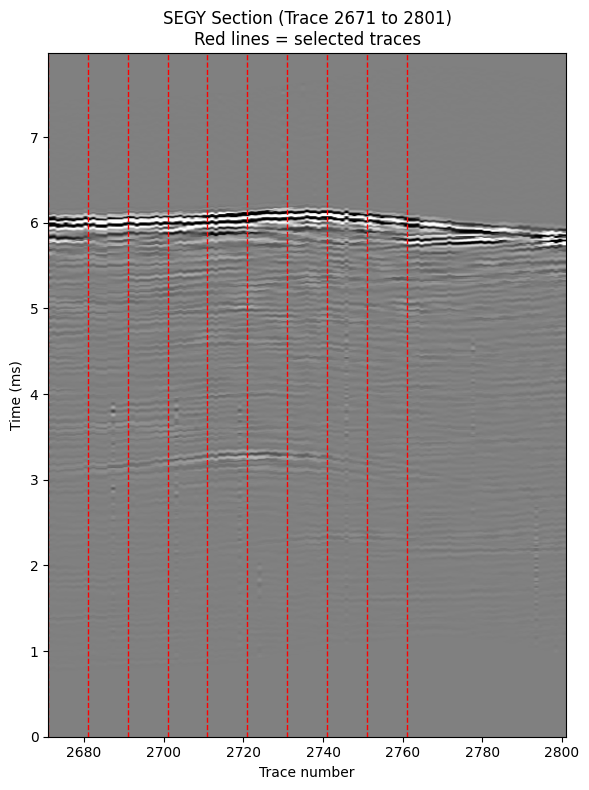

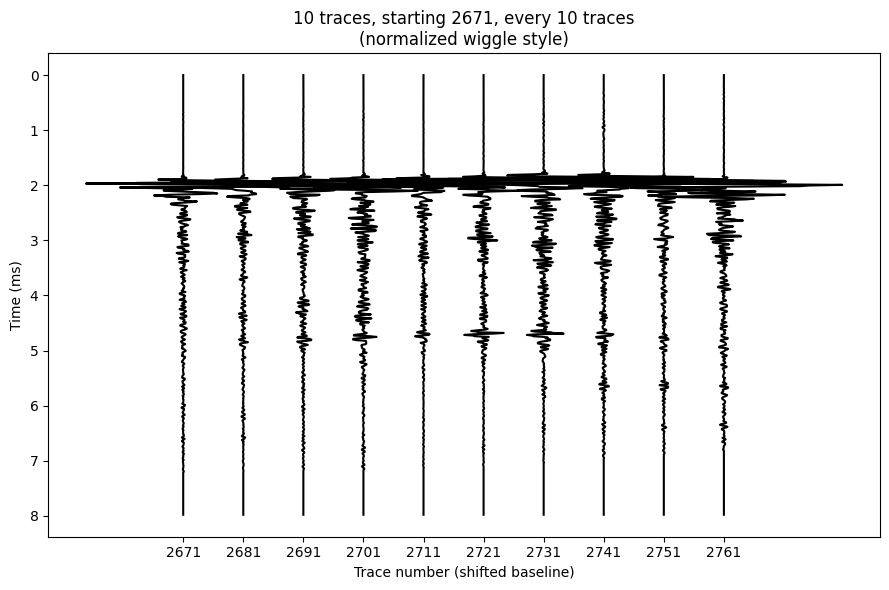

In [121]:
# pip install obspy numpy matplotlib
import numpy as np
import matplotlib.pyplot as plt
from obspy.io.segy.segy import _read_segy

SEGY_PATH = "MMT(2015)_sgy/X-16_20150928_135009_RAW_LF.sgy"
sf = _read_segy(SEGY_PATH, headonly=False)
n_traces = len(sf.traces)
print("Trace count:", n_traces)

# ---- Get sampling interval dt (milliseconds) ----
def get_dt_ms(segfile, fallback_ms=1.0):
    try:
        dt = segfile.binary_file_header.sample_interval_in_microseconds
        if dt and dt > 0:
            return dt / 1000.0
    except: pass
    try:
        dt = segfile.traces[0].stats.delta  # s
        if dt and dt > 0:
            return dt * 1000.0
    except: pass
    print(f"[WARN] No dt in headers; using fallback {fallback_ms} ms.")
    return fallback_ms

dt_ms = get_dt_ms(sf)

# ---- 2d trace range ----
start_trace = 2670
end_trace   = 2800
trace_range = range(start_trace, min(end_trace+1, n_traces))
n_show = len(trace_range)

# 
lengths = [sf.traces[i].data.size for i in trace_range]
ns = max(lengths)
section = np.zeros((ns, n_show), dtype=np.float32)

for j, idx in enumerate(trace_range):
    d = sf.traces[idx].data.astype(np.float32)
    section[:d.size, j] = d

times_ms = np.arange(ns) * dt_ms

# standarization
p99 = np.percentile(np.abs(section), 99)
if p99 > 0:
    section = np.clip(section / p99, -1, 1)

# ---- trace amplitude ----
trace_start = 2670   # starting trace
step = 10           # gap
n_waveforms = 10     # num of lines
trace_indices = [trace_start + i*step for i in range(n_waveforms)]

# ---- 2d + lines ----
plt.figure(figsize=(6, 8))
extent = [start_trace+1, end_trace+1, 0, times_ms[-1]]
plt.imshow(section, aspect='auto', extent=extent, cmap="gray")
for idx in trace_indices:
    if idx < n_traces:
        plt.axvline(idx+1, color='red', linestyle='--', linewidth=1)
plt.xlabel("Trace number")
plt.ylabel("Time (ms)")
plt.title(f"SEGY Section (Trace {start_trace+1} to {end_trace+1})\nRed lines = selected traces")
plt.tight_layout()
plt.show()

# ---- spectrum ----
# plt.figure(figsize=(14, 6))

# for k, idx in enumerate(trace_indices):
#     if idx >= n_traces:
#         continue
#     tr = sf.traces[idx].data.astype(np.float32)
#     t = np.arange(tr.size) * dt_ms
#     plt.plot(-(tr) + k*5000, t, color="black")
# plt.xticks(
#     ticks=range(len(trace_indices)), 
#     labels=[idx+1 for idx in trace_indices]  # trace
# )
# plt.gca().invert_yaxis()
# # plt.gca().invert_xaxis()  

# plt.xlabel("Trace index (shifted amplitude)")
# plt.ylabel("Time (ms)")
# plt.title(f"{n_waveforms} traces, starting {trace_start+1}, every {step} traces\n(mirrored wiggle style)")
# plt.tight_layout()
# plt.show()
# --------------
plt.figure(figsize=(9, 6))

amp_scale = 2000  # Control the maximum swing range of the wiggle (adjustable)

for k, idx in enumerate(trace_indices):
    if idx >= n_traces:
        continue
    tr = sf.traces[idx].data.astype(np.float32)
    t = np.arange(tr.size) * dt_ms

    # Normalize each trace individually to [-1, 1]
    p99 = np.percentile(np.abs(tr), 99)  # Use the 99th percentile for normalization to avoid outliers
    if p99 > 0:
        tr = tr / p99

    # Align x-axis ticks with trace numbers
    plt.plot(-tr * amp_scale + k*2000, t, color="black")

# x ==> trace number
plt.xticks(
    ticks=[k*2000 for k in range(len(trace_indices))],
    labels=[idx+1 for idx in trace_indices]
)

plt.gca().invert_yaxis()

plt.xlabel("Trace number (shifted baseline)")
plt.ylabel("Time (ms)")
plt.title(f"{n_waveforms} traces, starting {trace_start+1}, every {step} traces\n(normalized wiggle style)")
plt.tight_layout()
plt.show()




Trace count: 2481


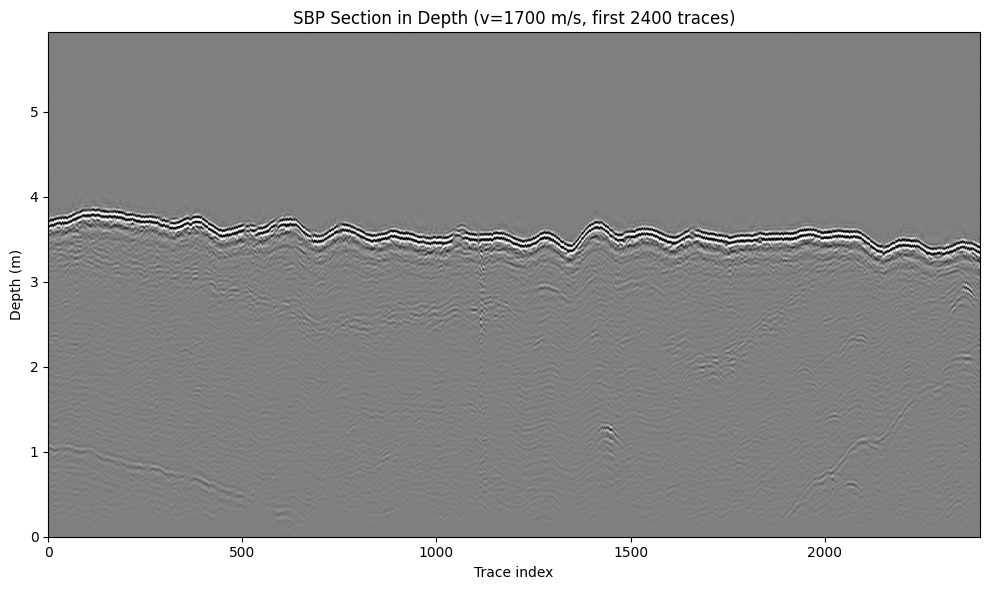

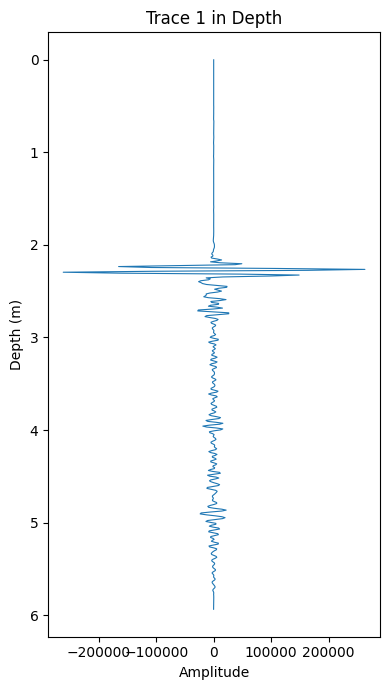

In [149]:
# pip install obspy numpy matplotlib
import numpy as np
import matplotlib.pyplot as plt
from obspy.io.segy.segy import _read_segy

SEGY_PATH = "processed/output_bp_5k_20k_TGC_power_n1p5.sgy"   # 改成你的文件路径
VEL_MS = 1700.0                  # 假定声速 (m/s)，例如海水/浅层沉积物
MAX_TRACES_TO_SHOW = 2400         # 最多显示多少道

# 读取 SEG-Y（ObsPy 容错好，适合 SBP/Chirp）
sf = _read_segy(SEGY_PATH, headonly=False)
n_traces = len(sf.traces)
print("Trace count:", n_traces)

# ---- 采样间隔 dt（毫秒），按二进制头/trace.stats/回退顺序获取 ----
def get_dt_ms(segfile, fallback_ms=1.0):
    try:
        dt = segfile.binary_file_header.sample_interval_in_microseconds
        if dt and dt > 0:
            return dt / 1000.0
    except: pass
    try:
        dt = segfile.traces[0].stats.delta  # s
        if dt and dt > 0:
            return dt * 1000.0
    except: pass
    print(f"[WARN] No dt in header; using fallback {fallback_ms} ms for axis.")
    return fallback_ms

dt_ms = get_dt_ms(sf)

# ---- 组剖面：把变长道补零到同一长度 ----
lengths = [tr.data.size for tr in sf.traces]
ns = max(lengths)
n_show = min(MAX_TRACES_TO_SHOW, n_traces)
section = np.zeros((ns, n_show), dtype=np.float32)
for i in range(n_show):
    d = sf.traces[i].data.astype(np.float32)
    section[:d.size, i] = d  # 不足部分补0

# ---- 时间轴(ms) → 深度轴(m)： z = v * t / 2 ----
times_ms = np.arange(ns) * dt_ms
times_s  = times_ms / 1000.0
depth_m  = 0.5 * VEL_MS * times_s  # 深度数组，与每一行对应

# ---- 简单归一化便于显示（可选）----
p99 = np.percentile(np.abs(section), 99)
if p99 > 0:
    section = np.clip(section / p99, -1, 1)

# ---- 画剖面：纵轴改为深度(m)，上0、下更大 ----
plt.figure(figsize=(10, 6))
extent = [0, n_show, 0.0, float(depth_m[-1])]  # y轴从0到最大深度
plt.imshow(section, aspect='auto', extent=extent, cmap="gray")
plt.xlabel("Trace index")
plt.ylabel("Depth (m)")
plt.title(f"SBP Section in Depth (v={VEL_MS:.0f} m/s, first {n_show} traces)")
plt.tight_layout()
plt.show()

# ---- 想看某一条道（竖着）也用深度轴 ----
trace_index = 0  # 改成你想看的道号（从0开始）
tr = sf.traces[trace_index].data.astype(np.float32)
z = depth_m[:tr.size]
plt.figure(figsize=(4, 7))
plt.plot(tr, z, linewidth=0.8)
plt.gca().invert_yaxis()  # 上浅下深
plt.xlabel("Amplitude")
plt.ylabel("Depth (m)")
plt.title(f"Trace {trace_index+1} in Depth")
plt.tight_layout()
plt.show()